In [ ]:
#hide
from fastai2.data.all import *
from nbdev.showdoc import show_doc

# Data block tutorial

> Using the data block accross all applications

In this tutorial, we'll see how to use the data block API on a variety of tasks and how to debug data blocks.

## Image classification

Let's begin with examples of image classification problems. There are two kinds of image classification problems: problems with single-label (each image as one given label) or multi-label (each image can have multiple or no labels at all). We will cover those two kinds here.

In [ ]:
from fastai2.vision.all import *

### MNIST (single label)

[MNIST](http://yann.lecun.com/exdb/mnist/) is a dataset of hand-written digits from 0 to 9. We can very easily load it in the data block API by answering the following questions:

- what are the types of our inputs and targets? Black and white images and labels.
- where is the data? In subfolders.
- how do we know if a sample is in the training or the validation set? By looking at the grandparent folder.
- how do we know the label of an image? By looking at the parent folder.

In terms of the API, those answers translate like this:

In [ ]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

Our types become blocks: one for images (using the black and white `PILImageBW` class) and one for categories. Searching subfolder for all image filenames is done by the `get_image_files` function. The split training/validation is done by using a `GrandparentSplitter`. And the function to get our targets (often called `y`) is `parent_label`.

In itself, a data block is just a blueprint. It does not do anything and does not check for errors. You have to feed it the source of the data to actually gather something. This is done with the `.dataloaders` method:

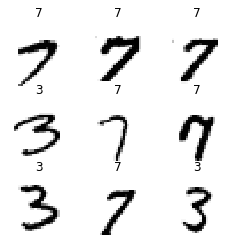

In [ ]:
dls = mnist.dataloaders(untar_data(URLs.MNIST_TINY))
dls.show_batch(max_n=9, figsize=(4,4))

If something went wrong in the previous step, or if you're just curious about what happened under the hood, use the `summary` method. It will go verbosely step by step, and you will see at which point the process failed.

In [ ]:
mnist.summary(untar_data(URLs.MNIST_TINY))

Setting-up type transforms pipelines
Found 1420 items
2 datasets of sizes 709,691
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/lgvaz/.fastai/data/mnist_tiny/train/7/730.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize
    starting from
      /home/lgvaz/.fastai/data/mnist_tiny/train/7/730.png
    applying parent_label gives
      7
    applying Categorize gives
      TensorCategory(1)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(1))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImageBW mode=L size=28x28, TensorCategory(1))
    applying ToTensor gives
      (TensorImageBW of size 1x28x28, TensorCategory(

Let's go over another example!

### Pets (single label)

The [Oxford IIIT Pets dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) is a dataset of pictures of dogs and cats, with 37 different breeds. A slight (but very) important difference with MNIST is that images are now not all of the same size. In MNIST they were all 28 by 28 pixels, but here they have different aspect ratios or dimensions. Therefore, we will need to add something to make them all the same size to be able to assemble them together in a batch. We will also see how to add data augmentation.

So let's go over the same questions as before and add two more:

- what are the types of our inputs and targets? Images and labels.
- where is the data? In subfolders.
- how do we know if a sample is in the training or the validation set? We'll take a random split.
- how do we know the label of an image? By looking at the parent folder.
- do we want to apply a function to a given sample? Yes, we need to resize everything to a given size.
- do we want to apply a function to a batch after it's created? Yes, we want data augmentation.

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=[attrgetter("name"), RegexLabeller(pat = r'^(.*)_\d+.jpg$')],
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms())

ValueError: get_y contains 2 functions, but must contain 1 (one for each target)

And like for MNIST, we can see how the answers to those questions directly translate in the API. Our types become blocks: one for images and one for categories. Searching subfolder for all image filenames is done by the `get_image_files` function. The split training/validation is done by using a `RandomSplitter`. The function to get our targets (often called `y`) is `parent_label`. We apply a resize at the item level and `aug_transforms()` at the batch level.

In [ ]:
dls = pets.dataloaders(untar_data(URLs.PETS)/"images")
dls.show_batch(max_n=9)

Now let's see how we can use the same API for a multi-label problem.

### Pascal (multi-label)

The [Pascal dataset](http://host.robots.ox.ac.uk/pascal/VOC/) is originally an object detection dataset (we have to predict where some objects are in pictures). But it contains lots of pictures with various objects in them, so it gives a great example for a multi-label problem. Let's download it and have a look at the data:

In [ ]:
pascal_source = untar_data(URLs.PASCAL_2007)
df = pd.read_csv(pascal_source/"train.csv")

In [ ]:
df.head()

So it looks like 

In [ ]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=pascal_source/"train"),
                   splitter=ColSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

In [ ]:
dls = pascal.dataloaders(df)
dls.show_batch()

In [ ]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=lambda x:pascal_source/"train"/f'{x[0]}',
                   splitter=ColSplitter(),
                   get_y=lambda x:x[1].split(' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

dls = pascal.dataloaders(df)
dls.show_batch()

In [ ]:
def _pascal_items(x): return (
    f'{pascal_source}/train/'+x.fname, x.labels.str.split())

pascal = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=_pascal_items,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

In [ ]:
dls = pascal.dataloaders(df)
dls.show_batch()

In [ ]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=lambda o:f'{pascal_source}/train/'+o.fname,
                   get_y=lambda o:o.labels.split(),
                   splitter=ColSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

In [ ]:
dls = pascal.dataloaders(df)
dls.show_batch()

## Image localization

### Segmentation

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, ImageBlock(cls=PILMask)),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=lambda o: untar_data(URLs.CAMVID_TINY)/'labels'/f'{o.stem}_P{o.suffix}',
    batch_tfms=aug_transforms())

dls = camvid.dataloaders(untar_data(URLs.CAMVID_TINY)/"images")
dls.show_batch(max_n=9, vmin=1, vmax=30)

### Points

In [ ]:
biwi_source = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = (biwi_source/'centers.pkl').load()

biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=lambda o:fn2ctr[o.name].flip(0),
                 batch_tfms=aug_transforms())

dls = biwi.dataloaders(biwi_source)
dls.show_batch(max_n=9)

### Bounding boxes

In [ ]:
coco_source = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco_source/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

In [ ]:
coco = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 getters=[noop, lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], 
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms(),
                 n_inp=1)

In [ ]:
dls = coco.dataloaders(coco_source)
dls.show_batch(max_n=9)

## Text

### Language model

In [ ]:
from fastai2.text.all import *

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/'texts.csv')

In [ ]:
imdb_lm = DataBlock(blocks=(TextBlock.from_df('text', is_lm=True),),
                    get_x=attrgetter('text'),
                    splitter=RandomSplitter())

In [ ]:
dls = imdb_lm.dataloaders(df, bs=64, seq_len=72)

In [ ]:
dls.show_batch(max_n=6)

### Text classification

In [ ]:
from fastai2.text.all import *

In [ ]:
imdb_clas = DataBlock(blocks=(TextBlock.from_df('text'), CategoryBlock),
                      get_x=attrgetter('text'),
                      get_y=attrgetter('label'),
                      splitter=RandomSplitter())

dls = imdb_clas.dataloaders(df, bs=64, seq_len=72)
dls.show_batch()

## Tabular data TODO

In [ ]:
from fastai2.tabular.core import *

In [ ]:
adult_source = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_source/'adult.csv')

In [ ]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter()(range_of(df))

In [ ]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names="salary", splits=splits)

In [ ]:
dls = to.dataloaders()
dls.show_batch()